C:\Users\dhire\AppData\Local\Temp\ipykernel_52616\1074338264.py:34: LangChainDeprecationWarning: The class `Bedrock` was deprecated in LangChain 0.0.34 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-aws package and should be used instead. To use it run `pip install -U :class:`~langchain-aws` and import as `from :class:`~langchain_aws import BedrockLLM``.
  llm = Bedrock(


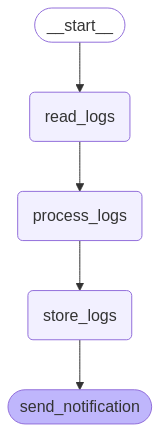

TypeError: WorkflowState.__init__() missing 1 required positional argument: 'lambda_functions'

In [1]:
from langgraph.graph import StateGraph
from dataclasses import dataclass
from langchain_community.llms import Bedrock
import boto3
import json
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["AWS_ACCESS_KEY_ID"]=os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"]=os.getenv("AWS_SECRET_ACCESS_KEY")
os.environ["AWS_REGION"]=os.getenv("AWS_REGION")


# Function to create a session
def create_aws_session():
    return boto3.Session(
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        region_name=os.environ["AWS_REGION"]
    )

# Initialize AWS Session
session = create_aws_session()

# Create AWS Clients using the session
sns_client = session.client("sns")
s3_client = session.client("s3")
logs_client = session.client("logs")
lambda_client = session.client("lambda")
bedrock_client = session.client("bedrock-runtime")

# Amazon Titan Model
llm = Bedrock(
    model_id="amazon.titan-text-express-v1",
    client=bedrock_client
)


# Define State Schema
@dataclass
class WorkflowState:
    lambda_functions: list
    log_group_name: str = "/aws/lambda/test1"
    logs: str = ""
    processed_logs: str = ""
    s3_link: str = ""

# Step 1: Read CloudWatch Logs
def read_cloudwatch_logs(state):
    response = logs_client.describe_log_streams(logGroupName=state.log_group_name)
    response = logs_client.describe_log_streams(logGroupName="/aws/lambda/test1")
    log_streams = response.get("logStreams", [])
    
    if log_streams:
        log_stream_name = log_streams[-1]["logStreamName"]
        log_events = logs_client.get_log_events(
            logGroupName="/aws/lambda/test1",
            logStreamName=log_stream_name
        )
        logs = "\n".join([event["message"] for event in log_events["events"]])
        state.logs = logs
    else:
        state.logs = "No logs found."
    return state

# Step 2: Process Logs with LLM
def process_logs(state):
    prompt = f"""Analyze the following CloudWatch logs and categorize errors as Critical, Warning, or Info. 
    Provide a summary of the errors found. Logs:
    {state.logs}"""
    response = llm.generate([prompt])
    state.processed_logs = response.generations[0][0].text  # Extract first response
    state.processed_logs = response
    return state

# Step 3: Store Logs in S3
def store_logs_in_s3(state):
    bucket_name = "testbucket-cw-logstore"
    file_name = "processed_logs.json"
    s3_client.put_object(Bucket=bucket_name, Key=file_name, Body=json.dumps({"logs": state.processed_logs.generations[0][0].text}))
    state.s3_link = f"https://s3.amazonaws.com/{bucket_name}/{file_name}"
    return state

# Step 4: Send SNS Notification
def send_sns_notification(state):
    message = f"CloudWatch Error Summary:\n{state.processed_logs}\n\nFull logs: {state.s3_link}"
    sns_client.publish(TopicArn="arn:aws:sns:us-east-1:050451365316:testsnstopic", Message=message, Subject="AWS Lambda Error Notification")
    return state

# Define Graph Workflow
graph = StateGraph(WorkflowState)
graph.add_node("read_logs", read_cloudwatch_logs)
graph.add_node("process_logs", process_logs)
graph.add_node("store_logs", store_logs_in_s3)
graph.add_node("send_notification", send_sns_notification)

graph.add_edge("read_logs", "process_logs")
graph.add_edge("process_logs", "store_logs")
graph.add_edge("store_logs", "send_notification")

graph.set_entry_point("read_logs")
workflow = graph.compile()


from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))


# Run the Workflow
workflow.invoke({"log_group_name": "/aws/lambda/test1", "logs": "", "processed_logs": "", "s3_link": ""})



In [51]:
def find_lambda_functions_by_prefix(prefix="your-prefix"):
    functions = []
    paginator = lambda_client.get_paginator("list_functions")
    for page in paginator.paginate():
        for function in page.get("Functions", []):
            function_name = function["FunctionName"]
            if function_name.startswith(prefix):
                functions.append(function_name)
    return functions
find_lambda_functions_by_prefix("test")

NameError: name 'lambda_client' is not defined